In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install dgl==2.4.0+cu121 -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
!pip install --force-reinstall numpy==1.26.4
!pip install lime matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB ? eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torchaudio-2.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c5a23b3ef2f53dd6b8f3bcaa4ec46e8f7900d2d2c495904972d39e8a1909ce24
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Acknowledgment:
# We express our sincere gratitude to the developers and contributors of the
# DGL library, particularly the example implementation of APPNP available at:
# https://github.com/dmlc/dgl/blob/master/examples/sparse/appnp.py
# This work served as a foundational reference and inspiration for our implementation.


In [ ]:
import dgl
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, auc
import numpy as np
import torch.nn as nn
import torch.nn.functional as nnFn
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
#cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
cn_features = np.array(list(cn_features_dict.values()))

mci_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI/Histogram_feature_MCI_FA_20bin.npy"
#mci_fa_feature_path = "/home/snu/Downloads/Histogram_feature_MCI_FA_20bin.npy"
mci_features_dict = np.load(mci_fa_feature_path, allow_pickle=True).item()
mci_features = np.array(list(mci_features_dict.values()))
cn_labels = np.zeros(cn_features.shape[0])
mci_labels = np.ones(mci_features.shape[0])

In [ ]:
X = np.vstack((cn_features, mci_features))
y = np.hstack((cn_labels, mci_labels))
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_nodes = X.shape[0]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1 # threshold
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src = src[mask]
dst = dst[mask]

graph = dgl.graph((src.cpu(), dst.cpu()), num_nodes=num_nodes, device='cpu')
graph = dgl.to_bidirected(graph)
graph = dgl.add_self_loop(graph)

graph = graph.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")


Graph Nodes: 300, Edges: 16508, Device: cuda


In [ ]:
# edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
# src, dst = edge_index
# graph = dgl.graph((src, dst))
# graph = dgl.to_bidirected(graph)
# graph = dgl.add_self_loop(graph)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# graph = graph.to(device)
# X_tensor = X_tensor.to(device)
# y_tensor = y_tensor.to(device)

# print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

Graph Nodes: 300, Edges: 90000, Device: cuda


In [ ]:
class APPNP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=512, dropout=0.2, num_hops=10, alpha=0.2):
        super().__init__()
        self.f_theta = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_size),
        )
        self.num_hops = num_hops
        self.A_dropout = nn.Dropout(dropout)
        self.alpha = alpha
        self.loss = self.cut_loss if cut else self.modularity_loss

    def forward(self, A_hat, X):
        Z_0 = Z = self.f_theta(X)
        for _ in range(self.num_hops):
            A_drop = dglsp.val_like(A_hat, self.A_dropout(A_hat.val))
            Z = (1 - self.alpha) * (A_drop @ Z) + self.alpha * Z_0
        return Z

    def modularity_loss(self, A, S):
        C = nnFn.softmax(S, dim=1)
        d = torch.sum(A, dim=1)
        m = torch.sum(A)
        B = A - torch.ger(d, d) / (2 * m)
        return (-1 / (2 * m)) * torch.trace(torch.mm(torch.mm(C.t(), B), C))

    def cut_loss(self, A, S):
        S = nnFn.softmax(S, dim=1)
        A_pool = torch.matmul(torch.matmul(A, S).t(), S)
        num = torch.trace(A_pool)
        D = torch.diag(torch.sum(A, dim=-1))
        D_pooled = torch.matmul(torch.matmul(D, S).t(), S)
        den = torch.trace(D_pooled)
        return -(num / den)

In [ ]:
indices = torch.stack(graph.edges())
N = graph.num_nodes()
A = dglsp.spmatrix(indices, shape=(N, N))
I = dglsp.identity(A.shape, device=device)
A_hat = A + I
D_hat = dglsp.diag(A_hat.sum(dim=1)) ** -0.5
A_hat = D_hat @ A_hat @ D_hat

In [ ]:
num_epochs = 5000
lambda_unsup = 0.01
cut = 1


Training fold 1
Epoch 0 | Sup: 0.6680 | Unsup: -0.9986 | Total: 0.6580
Epoch 500 | Sup: 0.0250 | Unsup: -0.8381 | Total: 0.0166
Epoch 1000 | Sup: 0.0048 | Unsup: -0.8105 | Total: -0.0034
Epoch 1500 | Sup: 0.0029 | Unsup: -0.8026 | Total: -0.0051
Epoch 2000 | Sup: 0.0031 | Unsup: -0.8044 | Total: -0.0050
Epoch 2500 | Sup: 0.0022 | Unsup: -0.8038 | Total: -0.0058
Epoch 3000 | Sup: 0.0014 | Unsup: -0.8030 | Total: -0.0066
Epoch 3500 | Sup: 0.0014 | Unsup: -0.8045 | Total: -0.0067
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8180 | Total: -0.0059
Epoch 4500 | Sup: 0.0012 | Unsup: -0.8100 | Total: -0.0069
Fold 1 | Acc: 0.7741 | Prec: 0.7514 | Rec: 0.8867 | F1: 0.8135 | Loss: 0.6564 | AUC: 0.8323

Training fold 2
Epoch 0 | Sup: 0.6819 | Unsup: -0.9986 | Total: 0.6719
Epoch 500 | Sup: 0.0321 | Unsup: -0.8292 | Total: 0.0238
Epoch 1000 | Sup: 0.0078 | Unsup: -0.8038 | Total: -0.0002
Epoch 1500 | Sup: 0.0099 | Unsup: -0.7992 | Total: 0.0020
Epoch 2000 | Sup: 0.0039 | Unsup: -0.7887 | Total: -0.0040
Ep

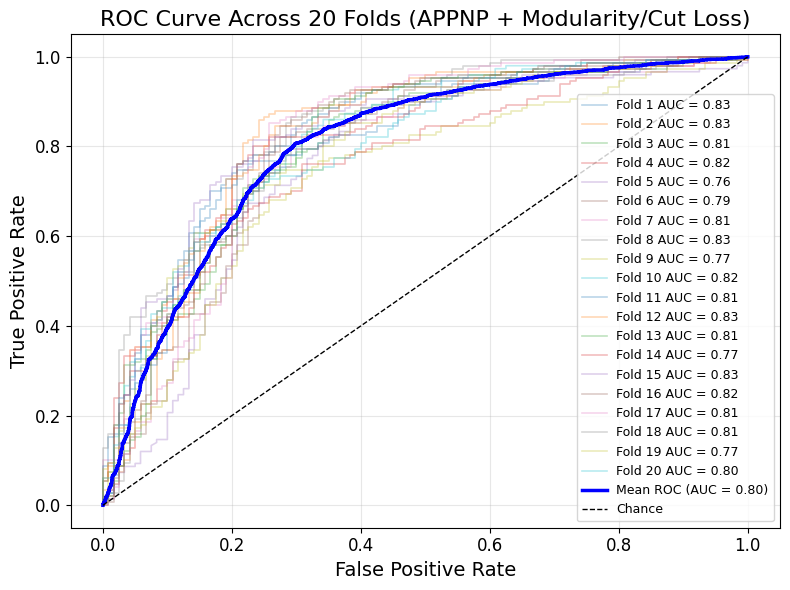

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, log_loss, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np

A_dense = A_hat.to_dense()

sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    ce_loss = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(A_hat, X_tensor)

        sup_loss = ce_loss(out[train_mask], y_tensor[train_mask])
        unsup_loss = model.cut_loss(A_dense, out) if cut else model.modularity_loss(A_dense, out)
        total_loss = sup_loss + lambda_unsup * unsup_loss

        if torch.isnan(total_loss) or torch.isinf(total_loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        total_loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Sup: {sup_loss.item():.4f} | Unsup: {unsup_loss.item():.4f} | Total: {total_loss.item():.4f}")


    model.eval()
    with torch.no_grad():
        logits = model(A_hat, X_tensor)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    auc_val = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(auc_val)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {auc_val:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


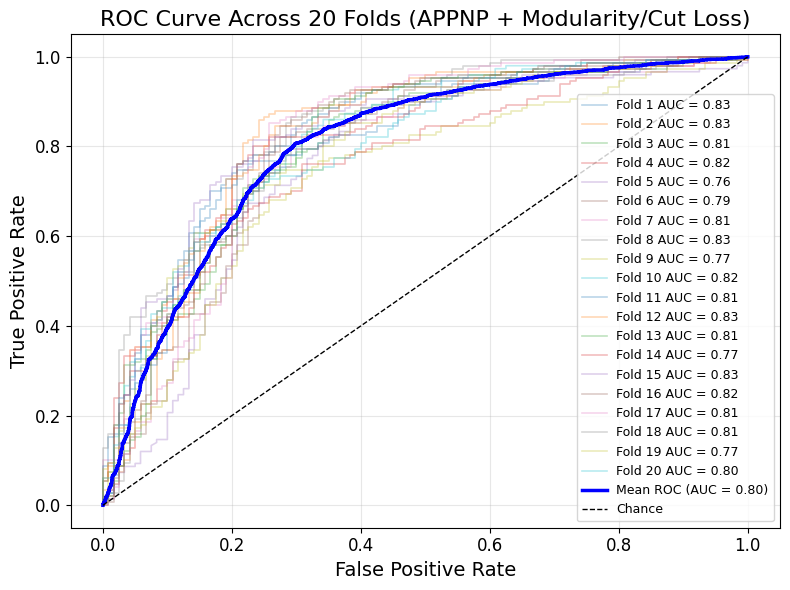

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, lw=1.2, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2.5, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1, label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (APPNP + Modularity/Cut Loss)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### lambda = 0.05

Training fold 1
Epoch 0 | Sup: 0.6977 | Unsup: -0.9980 | Total: 0.6478
Epoch 500 | Sup: 0.0289 | Unsup: -0.8479 | Total: -0.0135
Epoch 1000 | Sup: 0.0077 | Unsup: -0.8253 | Total: -0.0336
Epoch 1500 | Sup: 0.0079 | Unsup: -0.8182 | Total: -0.0330
Epoch 2000 | Sup: 0.0040 | Unsup: -0.8245 | Total: -0.0373
Epoch 2500 | Sup: 0.0031 | Unsup: -0.8352 | Total: -0.0387
Epoch 3000 | Sup: 0.0022 | Unsup: -0.8412 | Total: -0.0398
Epoch 3500 | Sup: 0.0040 | Unsup: -0.8543 | Total: -0.0387
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8722 | Total: -0.0413
Epoch 4500 | Sup: 0.0035 | Unsup: -0.8894 | Total: -0.0410
Fold 1 | Acc: 0.5704 | Prec: 0.5649 | Rec: 0.9867 | F1: 0.7184 | Loss: 1.0818

Training fold 2
Epoch 0 | Sup: 0.7156 | Unsup: -0.9989 | Total: 0.6656
Epoch 500 | Sup: 0.0347 | Unsup: -0.8350 | Total: -0.0071
Epoch 1000 | Sup: 0.0125 | Unsup: -0.8142 | Total: -0.0282
Epoch 1500 | Sup: 0.0049 | Unsup: -0.8126 | Total: -0.0357
Epoch 2000 | Sup: 0.0049 | Unsup: -0.8220 | Total: -0.0362
Epoch 2500 | Sup: 0.0036 | Unsup: -0.8174 | Total: -0.0373
Epoch 3000 | Sup: 0.0043 | Unsup: -0.8244 | Total: -0.0369
Epoch 3500 | Sup: 0.0029 | Unsup: -0.8206 | Total: -0.0381
Epoch 4000 | Sup: 0.0042 | Unsup: -0.8264 | Total: -0.0372
Epoch 4500 | Sup: 0.0047 | Unsup: -0.8559 | Total: -0.0381
Fold 2 | Acc: 0.6111 | Prec: 0.5889 | Rec: 0.9933 | F1: 0.7395 | Loss: 0.9077

Training fold 3
Epoch 0 | Sup: 0.7376 | Unsup: -0.9983 | Total: 0.6877
Epoch 500 | Sup: 0.0318 | Unsup: -0.8304 | Total: -0.0097
Epoch 1000 | Sup: 0.0115 | Unsup: -0.8134 | Total: -0.0292
Epoch 1500 | Sup: 0.0048 | Unsup: -0.7984 | Total: -0.0352
Epoch 2000 | Sup: 0.0031 | Unsup: -0.8006 | Total: -0.0369
Epoch 2500 | Sup: 0.0039 | Unsup: -0.8082 | Total: -0.0366
Epoch 3000 | Sup: 0.0036 | Unsup: -0.8143 | Total: -0.0371
Epoch 3500 | Sup: 0.0030 | Unsup: -0.8127 | Total: -0.0376
Epoch 4000 | Sup: 0.0035 | Unsup: -0.8137 | Total: -0.0372
Epoch 4500 | Sup: 0.0024 | Unsup: -0.8219 | Total: -0.0387
Fold 3 | Acc: 0.7667 | Prec: 0.7403 | Rec: 0.8933 | F1: 0.8097 | Loss: 0.6429

Training fold 4
Epoch 0 | Sup: 0.7064 | Unsup: -0.9984 | Total: 0.6565
Epoch 500 | Sup: 0.0271 | Unsup: -0.8287 | Total: -0.0143
Epoch 1000 | Sup: 0.0062 | Unsup: -0.8113 | Total: -0.0344
Epoch 1500 | Sup: 0.0053 | Unsup: -0.8073 | Total: -0.0351
Epoch 2000 | Sup: 0.0031 | Unsup: -0.8065 | Total: -0.0373
Epoch 2500 | Sup: 0.0028 | Unsup: -0.8063 | Total: -0.0375
Epoch 3000 | Sup: 0.0031 | Unsup: -0.8184 | Total: -0.0378
Epoch 3500 | Sup: 0.0022 | Unsup: -0.8102 | Total: -0.0383
Epoch 4000 | Sup: 0.0034 | Unsup: -0.8162 | Total: -0.0374
Epoch 4500 | Sup: 0.0029 | Unsup: -0.8151 | Total: -0.0378
Fold 4 | Acc: 0.7667 | Prec: 0.7605 | Rec: 0.8467 | F1: 0.8013 | Loss: 0.6609

Training fold 5
Epoch 0 | Sup: 0.7173 | Unsup: -0.9989 | Total: 0.6674
Epoch 500 | Sup: 0.0094 | Unsup: -0.8609 | Total: -0.0337
Epoch 1000 | Sup: 0.0037 | Unsup: -0.8571 | Total: -0.0391
Epoch 1500 | Sup: 0.0031 | Unsup: -0.8525 | Total: -0.0395
Epoch 2000 | Sup: 0.0022 | Unsup: -0.8567 | Total: -0.0407
Epoch 2500 | Sup: 0.0014 | Unsup: -0.8581 | Total: -0.0415
Epoch 3000 | Sup: 0.0015 | Unsup: -0.8569 | Total: -0.0414
Epoch 3500 | Sup: 0.0012 | Unsup: -0.8586 | Total: -0.0417
Epoch 4000 | Sup: 0.0014 | Unsup: -0.8606 | Total: -0.0417
Epoch 4500 | Sup: 0.0014 | Unsup: -0.8615 | Total: -0.0416
Fold 5 | Acc: 0.7370 | Prec: 0.7090 | Rec: 0.8933 | F1: 0.7906 | Loss: 1.2833

Training fold 6
Epoch 0 | Sup: 0.6961 | Unsup: -0.9987 | Total: 0.6461
Epoch 500 | Sup: 0.0413 | Unsup: -0.8459 | Total: -0.0010
Epoch 1000 | Sup: 0.0059 | Unsup: -0.8196 | Total: -0.0351
Epoch 1500 | Sup: 0.0053 | Unsup: -0.8183 | Total: -0.0356
Epoch 2000 | Sup: 0.0037 | Unsup: -0.8175 | Total: -0.0372
Epoch 2500 | Sup: 0.0027 | Unsup: -0.8206 | Total: -0.0384
Epoch 3000 | Sup: 0.0023 | Unsup: -0.8207 | Total: -0.0387
Epoch 3500 | Sup: 0.0028 | Unsup: -0.8221 | Total: -0.0383
Epoch 4000 | Sup: 0.0033 | Unsup: -0.8276 | Total: -0.0381
Epoch 4500 | Sup: 0.0019 | Unsup: -0.8263 | Total: -0.0394
Fold 6 | Acc: 0.7667 | Prec: 0.7771 | Rec: 0.8133 | F1: 0.7948 | Loss: 0.7194

Training fold 7
Epoch 0 | Sup: 0.6899 | Unsup: -0.9983 | Total: 0.6400
Epoch 500 | Sup: 0.0305 | Unsup: -0.8413 | Total: -0.0116
Epoch 1000 | Sup: 0.0092 | Unsup: -0.8260 | Total: -0.0321
Epoch 1500 | Sup: 0.0037 | Unsup: -0.8167 | Total: -0.0371
Epoch 2000 | Sup: 0.0029 | Unsup: -0.8239 | Total: -0.0383
Epoch 2500 | Sup: 0.0082 | Unsup: -0.8279 | Total: -0.0332
Epoch 3000 | Sup: 0.0019 | Unsup: -0.8340 | Total: -0.0398
Epoch 3500 | Sup: 0.0027 | Unsup: -0.8339 | Total: -0.0390
Epoch 4000 | Sup: 0.0019 | Unsup: -0.8354 | Total: -0.0398
Epoch 4500 | Sup: 0.0035 | Unsup: -0.8459 | Total: -0.0387
Fold 7 | Acc: 0.7333 | Prec: 0.7010 | Rec: 0.9067 | F1: 0.7907 | Loss: 0.7483

Training fold 8
Epoch 0 | Sup: 0.7070 | Unsup: -0.9987 | Total: 0.6571
Epoch 500 | Sup: 0.0426 | Unsup: -0.8465 | Total: 0.0003
Epoch 1000 | Sup: 0.0082 | Unsup: -0.8239 | Total: -0.0330
Epoch 1500 | Sup: 0.0061 | Unsup: -0.8243 | Total: -0.0351
Epoch 2000 | Sup: 0.0050 | Unsup: -0.8367 | Total: -0.0368
Epoch 2500 | Sup: 0.0063 | Unsup: -0.8307 | Total: -0.0352
Epoch 3000 | Sup: 0.0035 | Unsup: -0.8507 | Total: -0.0390
Epoch 3500 | Sup: 0.0061 | Unsup: -0.8598 | Total: -0.0369
Epoch 4000 | Sup: 0.0030 | Unsup: -0.8624 | Total: -0.0401
Epoch 4500 | Sup: 0.0025 | Unsup: -0.8700 | Total: -0.0410
Fold 8 | Acc: 0.6000 | Prec: 0.5814 | Rec: 1.0000 | F1: 0.7353 | Loss: 1.0906

Training fold 9
Epoch 0 | Sup: 0.6730 | Unsup: -0.9983 | Total: 0.6230
Epoch 500 | Sup: 0.0261 | Unsup: -0.8256 | Total: -0.0151
Epoch 1000 | Sup: 0.0085 | Unsup: -0.8108 | Total: -0.0321
Epoch 1500 | Sup: 0.0038 | Unsup: -0.8059 | Total: -0.0365
Epoch 2000 | Sup: 0.0034 | Unsup: -0.8077 | Total: -0.0370
Epoch 2500 | Sup: 0.0019 | Unsup: -0.8079 | Total: -0.0385
Epoch 3000 | Sup: 0.0031 | Unsup: -0.8106 | Total: -0.0375
Epoch 3500 | Sup: 0.0023 | Unsup: -0.8127 | Total: -0.0384
Epoch 4000 | Sup: 0.0024 | Unsup: -0.8134 | Total: -0.0383
Epoch 4500 | Sup: 0.0016 | Unsup: -0.8182 | Total: -0.0393
Fold 9 | Acc: 0.7259 | Prec: 0.8065 | Rec: 0.6667 | F1: 0.7299 | Loss: 0.8511

Training fold 10
Epoch 0 | Sup: 0.6898 | Unsup: -0.9986 | Total: 0.6398
Epoch 500 | Sup: 0.0229 | Unsup: -0.8345 | Total: -0.0188
Epoch 1000 | Sup: 0.0068 | Unsup: -0.8164 | Total: -0.0340
Epoch 1500 | Sup: 0.0041 | Unsup: -0.8209 | Total: -0.0370
Epoch 2000 | Sup: 0.0033 | Unsup: -0.8141 | Total: -0.0374
Epoch 2500 | Sup: 0.0026 | Unsup: -0.8210 | Total: -0.0385
Epoch 3000 | Sup: 0.0029 | Unsup: -0.8202 | Total: -0.0381
Epoch 3500 | Sup: 0.0033 | Unsup: -0.8269 | Total: -0.0381
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8307 | Total: -0.0392
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8339 | Total: -0.0397
Fold 10 | Acc: 0.7556 | Prec: 0.7143 | Rec: 0.9333 | F1: 0.8092 | Loss: 0.8971

Training fold 11
Epoch 0 | Sup: 0.7077 | Unsup: -0.9983 | Total: 0.6578
Epoch 500 | Sup: 0.0243 | Unsup: -0.8383 | Total: -0.0176
Epoch 1000 | Sup: 0.0072 | Unsup: -0.8179 | Total: -0.0337
Epoch 1500 | Sup: 0.0038 | Unsup: -0.8175 | Total: -0.0371
Epoch 2000 | Sup: 0.0042 | Unsup: -0.8277 | Total: -0.0372
Epoch 2500 | Sup: 0.0030 | Unsup: -0.8229 | Total: -0.0381
Epoch 3000 | Sup: 0.0047 | Unsup: -0.8320 | Total: -0.0369
Epoch 3500 | Sup: 0.0017 | Unsup: -0.8352 | Total: -0.0400
Epoch 4000 | Sup: 0.0027 | Unsup: -0.8391 | Total: -0.0392
Epoch 4500 | Sup: 0.0013 | Unsup: -0.8466 | Total: -0.0410
Fold 11 | Acc: 0.7630 | Prec: 0.7363 | Rec: 0.8933 | F1: 0.8072 | Loss: 0.6362

Training fold 12
Epoch 0 | Sup: 0.6939 | Unsup: -0.9985 | Total: 0.6439
Epoch 500 | Sup: 0.0296 | Unsup: -0.8324 | Total: -0.0120
Epoch 1000 | Sup: 0.0069 | Unsup: -0.8065 | Total: -0.0334
Epoch 1500 | Sup: 0.0042 | Unsup: -0.8104 | Total: -0.0363
Epoch 2000 | Sup: 0.0067 | Unsup: -0.8205 | Total: -0.0343
Epoch 2500 | Sup: 0.0026 | Unsup: -0.8215 | Total: -0.0385
Epoch 3000 | Sup: 0.0025 | Unsup: -0.8298 | Total: -0.0390
Epoch 3500 | Sup: 0.0021 | Unsup: -0.8352 | Total: -0.0397
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8474 | Total: -0.0401
Epoch 4500 | Sup: 0.0037 | Unsup: -0.8534 | Total: -0.0390
Fold 12 | Acc: 0.6444 | Prec: 0.6134 | Rec: 0.9733 | F1: 0.7526 | Loss: 0.8611

Training fold 13
Epoch 0 | Sup: 0.6920 | Unsup: -0.9986 | Total: 0.6421
Epoch 500 | Sup: 0.0301 | Unsup: -0.8466 | Total: -0.0123
Epoch 1000 | Sup: 0.0059 | Unsup: -0.8291 | Total: -0.0356
Epoch 1500 | Sup: 0.0049 | Unsup: -0.8260 | Total: -0.0364
Epoch 2000 | Sup: 0.0030 | Unsup: -0.8262 | Total: -0.0383
Epoch 2500 | Sup: 0.0036 | Unsup: -0.8368 | Total: -0.0382
Epoch 3000 | Sup: 0.0026 | Unsup: -0.8364 | Total: -0.0392
Epoch 3500 | Sup: 0.0018 | Unsup: -0.8387 | Total: -0.0401
Epoch 4000 | Sup: 0.0015 | Unsup: -0.8413 | Total: -0.0405
Epoch 4500 | Sup: 0.0030 | Unsup: -0.8411 | Total: -0.0391
Fold 13 | Acc: 0.7741 | Prec: 0.7330 | Rec: 0.9333 | F1: 0.8211 | Loss: 0.8365

Training fold 14
Epoch 0 | Sup: 0.7008 | Unsup: -0.9987 | Total: 0.6508
Epoch 500 | Sup: 0.0299 | Unsup: -0.8344 | Total: -0.0118
Epoch 1000 | Sup: 0.0076 | Unsup: -0.8149 | Total: -0.0331
Epoch 1500 | Sup: 0.0053 | Unsup: -0.8116 | Total: -0.0353
Epoch 2000 | Sup: 0.0055 | Unsup: -0.8145 | Total: -0.0352
Epoch 2500 | Sup: 0.0025 | Unsup: -0.8152 | Total: -0.0383
Epoch 3000 | Sup: 0.0034 | Unsup: -0.8246 | Total: -0.0378
Epoch 3500 | Sup: 0.0025 | Unsup: -0.8181 | Total: -0.0384
Epoch 4000 | Sup: 0.0022 | Unsup: -0.8189 | Total: -0.0388
Epoch 4500 | Sup: 0.0024 | Unsup: -0.8239 | Total: -0.0388
Fold 14 | Acc: 0.7259 | Prec: 0.7794 | Rec: 0.7067 | F1: 0.7413 | Loss: 0.7874

Training fold 15
Epoch 0 | Sup: 0.6786 | Unsup: -0.9983 | Total: 0.6287
Epoch 500 | Sup: 0.0292 | Unsup: -0.8252 | Total: -0.0120
Epoch 1000 | Sup: 0.0069 | Unsup: -0.8028 | Total: -0.0333
Epoch 1500 | Sup: 0.0053 | Unsup: -0.7938 | Total: -0.0344
Epoch 2000 | Sup: 0.0048 | Unsup: -0.8035 | Total: -0.0354
Epoch 2500 | Sup: 0.0033 | Unsup: -0.8009 | Total: -0.0368
Epoch 3000 | Sup: 0.0039 | Unsup: -0.8077 | Total: -0.0365
Epoch 3500 | Sup: 0.0021 | Unsup: -0.8052 | Total: -0.0382
Epoch 4000 | Sup: 0.0034 | Unsup: -0.8138 | Total: -0.0372
Epoch 4500 | Sup: 0.0024 | Unsup: -0.8169 | Total: -0.0385
Fold 15 | Acc: 0.7778 | Prec: 0.7647 | Rec: 0.8667 | F1: 0.8125 | Loss: 0.7013

Training fold 16
Epoch 0 | Sup: 0.6897 | Unsup: -0.9981 | Total: 0.6398
Epoch 500 | Sup: 0.0250 | Unsup: -0.8463 | Total: -0.0173
Epoch 1000 | Sup: 0.0044 | Unsup: -0.8328 | Total: -0.0372
Epoch 1500 | Sup: 0.0022 | Unsup: -0.8321 | Total: -0.0394
Epoch 2000 | Sup: 0.0027 | Unsup: -0.8343 | Total: -0.0390
Epoch 2500 | Sup: 0.0019 | Unsup: -0.8353 | Total: -0.0399
Epoch 3000 | Sup: 0.0021 | Unsup: -0.8339 | Total: -0.0396
Epoch 3500 | Sup: 0.0016 | Unsup: -0.8323 | Total: -0.0400
Epoch 4000 | Sup: 0.0021 | Unsup: -0.8349 | Total: -0.0396
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8403 | Total: -0.0400
Fold 16 | Acc: 0.7741 | Prec: 0.7459 | Rec: 0.9000 | F1: 0.8157 | Loss: 0.8572

Training fold 17
Epoch 0 | Sup: 0.6913 | Unsup: -0.9985 | Total: 0.6413
Epoch 500 | Sup: 0.0289 | Unsup: -0.8357 | Total: -0.0129
Epoch 1000 | Sup: 0.0120 | Unsup: -0.8170 | Total: -0.0289
Epoch 1500 | Sup: 0.0046 | Unsup: -0.8245 | Total: -0.0367
Epoch 2000 | Sup: 0.0031 | Unsup: -0.8143 | Total: -0.0376
Epoch 2500 | Sup: 0.0037 | Unsup: -0.8242 | Total: -0.0375
Epoch 3000 | Sup: 0.0035 | Unsup: -0.8202 | Total: -0.0375
Epoch 3500 | Sup: 0.0031 | Unsup: -0.8289 | Total: -0.0383
Epoch 4000 | Sup: 0.0029 | Unsup: -0.8392 | Total: -0.0390
Epoch 4500 | Sup: 0.0029 | Unsup: -0.8390 | Total: -0.0391
Fold 17 | Acc: 0.7444 | Prec: 0.6976 | Rec: 0.9533 | F1: 0.8056 | Loss: 0.8253

Training fold 18
Epoch 0 | Sup: 0.6973 | Unsup: -0.9988 | Total: 0.6474
Epoch 500 | Sup: 0.0230 | Unsup: -0.8292 | Total: -0.0185
Epoch 1000 | Sup: 0.0085 | Unsup: -0.8201 | Total: -0.0325
Epoch 1500 | Sup: 0.0039 | Unsup: -0.8132 | Total: -0.0367
Epoch 2000 | Sup: 0.0065 | Unsup: -0.8153 | Total: -0.0343
Epoch 2500 | Sup: 0.0028 | Unsup: -0.8165 | Total: -0.0380
Epoch 3000 | Sup: 0.0034 | Unsup: -0.8239 | Total: -0.0378
Epoch 3500 | Sup: 0.0029 | Unsup: -0.8240 | Total: -0.0383
Epoch 4000 | Sup: 0.0030 | Unsup: -0.8181 | Total: -0.0379
Epoch 4500 | Sup: 0.0015 | Unsup: -0.8242 | Total: -0.0397
Fold 18 | Acc: 0.7556 | Prec: 0.7500 | Rec: 0.8400 | F1: 0.7925 | Loss: 0.8224

Training fold 19
Epoch 0 | Sup: 0.7174 | Unsup: -0.9987 | Total: 0.6675
Epoch 500 | Sup: 0.0345 | Unsup: -0.8500 | Total: -0.0080
Epoch 1000 | Sup: 0.0104 | Unsup: -0.8305 | Total: -0.0311
Epoch 1500 | Sup: 0.0080 | Unsup: -0.8339 | Total: -0.0337
Epoch 2000 | Sup: 0.0038 | Unsup: -0.8343 | Total: -0.0380
Epoch 2500 | Sup: 0.0033 | Unsup: -0.8277 | Total: -0.0381
Epoch 3000 | Sup: 0.0024 | Unsup: -0.8333 | Total: -0.0393
Epoch 3500 | Sup: 0.0052 | Unsup: -0.8399 | Total: -0.0368
Epoch 4000 | Sup: 0.0016 | Unsup: -0.8433 | Total: -0.0406
Epoch 4500 | Sup: 0.0018 | Unsup: -0.8449 | Total: -0.0404
Fold 19 | Acc: 0.7259 | Prec: 0.6919 | Rec: 0.9133 | F1: 0.7874 | Loss: 0.9716

Training fold 20
Epoch 0 | Sup: 0.7228 | Unsup: -0.9985 | Total: 0.6729
Epoch 500 | Sup: 0.0366 | Unsup: -0.8464 | Total: -0.0057
Epoch 1000 | Sup: 0.0086 | Unsup: -0.8165 | Total: -0.0322
Epoch 1500 | Sup: 0.0057 | Unsup: -0.8065 | Total: -0.0346
Epoch 2000 | Sup: 0.0036 | Unsup: -0.8135 | Total: -0.0370
Epoch 2500 | Sup: 0.0031 | Unsup: -0.8207 | Total: -0.0379
Epoch 3000 | Sup: 0.0035 | Unsup: -0.8264 | Total: -0.0378
Epoch 3500 | Sup: 0.0051 | Unsup: -0.8468 | Total: -0.0372
Epoch 4000 | Sup: 0.0033 | Unsup: -0.8491 | Total: -0.0391
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8559 | Total: -0.0408
Fold 20 | Acc: 0.5963 | Prec: 0.5792 | Rec: 1.0000 | F1: 0.7335 | Loss: 1.0238

==== APPNP + Modularity Loss Average Results ====
Avg Accuracy: 0.7157
Avg Precision: 0.7018
Avg Recall: 0.8957
Avg F1 Score: 0.7794
Avg Cross-Entropy Loss: 0.8603

### lambda = 0.03

Training fold 1
Epoch 0 | Sup: 0.7089 | Unsup: -0.9988 | Total: 0.6790
Epoch 500 | Sup: 0.0296 | Unsup: -0.8378 | Total: 0.0045
Epoch 1000 | Sup: 0.0077 | Unsup: -0.8196 | Total: -0.0169
Epoch 1500 | Sup: 0.0060 | Unsup: -0.8186 | Total: -0.0186
Epoch 2000 | Sup: 0.0042 | Unsup: -0.8269 | Total: -0.0206
Epoch 2500 | Sup: 0.0030 | Unsup: -0.8286 | Total: -0.0218
Epoch 3000 | Sup: 0.0045 | Unsup: -0.8226 | Total: -0.0202
Epoch 3500 | Sup: 0.0016 | Unsup: -0.8299 | Total: -0.0233
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8270 | Total: -0.0226
Epoch 4500 | Sup: 0.0016 | Unsup: -0.8304 | Total: -0.0233
Fold 1 | Acc: 0.7519 | Prec: 0.7044 | Rec: 0.9533 | F1: 0.8102 | Loss: 0.7380

Training fold 2
Epoch 0 | Sup: 0.6998 | Unsup: -0.9987 | Total: 0.6698
Epoch 500 | Sup: 0.0301 | Unsup: -0.8280 | Total: 0.0053
Epoch 1000 | Sup: 0.0067 | Unsup: -0.8002 | Total: -0.0173
Epoch 1500 | Sup: 0.0039 | Unsup: -0.8083 | Total: -0.0204
Epoch 2000 | Sup: 0.0039 | Unsup: -0.7966 | Total: -0.0200
Epoch 2500 | Sup: 0.0041 | Unsup: -0.8045 | Total: -0.0200
Epoch 3000 | Sup: 0.0035 | Unsup: -0.8078 | Total: -0.0207
Epoch 3500 | Sup: 0.0027 | Unsup: -0.8148 | Total: -0.0218
Epoch 4000 | Sup: 0.0029 | Unsup: -0.8122 | Total: -0.0214
Epoch 4500 | Sup: 0.0018 | Unsup: -0.8147 | Total: -0.0226
Fold 2 | Acc: 0.7963 | Prec: 0.7746 | Rec: 0.8933 | F1: 0.8297 | Loss: 0.6604

Training fold 3
Epoch 0 | Sup: 0.6969 | Unsup: -0.9985 | Total: 0.6669
Epoch 500 | Sup: 0.0383 | Unsup: -0.8320 | Total: 0.0134
Epoch 1000 | Sup: 0.0067 | Unsup: -0.7978 | Total: -0.0172
Epoch 1500 | Sup: 0.0065 | Unsup: -0.7950 | Total: -0.0173
Epoch 2000 | Sup: 0.0036 | Unsup: -0.8005 | Total: -0.0204
Epoch 2500 | Sup: 0.0040 | Unsup: -0.7932 | Total: -0.0198
Epoch 3000 | Sup: 0.0031 | Unsup: -0.7971 | Total: -0.0208
Epoch 3500 | Sup: 0.0023 | Unsup: -0.8046 | Total: -0.0218
Epoch 4000 | Sup: 0.0018 | Unsup: -0.8098 | Total: -0.0225
Epoch 4500 | Sup: 0.0020 | Unsup: -0.7982 | Total: -0.0219
Fold 3 | Acc: 0.7630 | Prec: 0.7560 | Rec: 0.8467 | F1: 0.7987 | Loss: 0.6848

Training fold 4
Epoch 0 | Sup: 0.7074 | Unsup: -0.9986 | Total: 0.6774
Epoch 500 | Sup: 0.0323 | Unsup: -0.8325 | Total: 0.0073
Epoch 1000 | Sup: 0.0093 | Unsup: -0.8073 | Total: -0.0149
Epoch 1500 | Sup: 0.0037 | Unsup: -0.8058 | Total: -0.0205
Epoch 2000 | Sup: 0.0033 | Unsup: -0.8044 | Total: -0.0208
Epoch 2500 | Sup: 0.0034 | Unsup: -0.8055 | Total: -0.0208
Epoch 3000 | Sup: 0.0019 | Unsup: -0.8071 | Total: -0.0223
Epoch 3500 | Sup: 0.0023 | Unsup: -0.8018 | Total: -0.0217
Epoch 4000 | Sup: 0.0017 | Unsup: -0.8047 | Total: -0.0225
Epoch 4500 | Sup: 0.0021 | Unsup: -0.8008 | Total: -0.0219
Fold 4 | Acc: 0.7630 | Prec: 0.7722 | Rec: 0.8133 | F1: 0.7922 | Loss: 0.7315

Training fold 5
Epoch 0 | Sup: 0.7176 | Unsup: -0.9984 | Total: 0.6877
Epoch 500 | Sup: 0.0140 | Unsup: -0.8610 | Total: -0.0119
Epoch 1000 | Sup: 0.0036 | Unsup: -0.8542 | Total: -0.0220
Epoch 1500 | Sup: 0.0029 | Unsup: -0.8494 | Total: -0.0226
Epoch 2000 | Sup: 0.0013 | Unsup: -0.8510 | Total: -0.0242
Epoch 2500 | Sup: 0.0014 | Unsup: -0.8508 | Total: -0.0242
Epoch 3000 | Sup: 0.0016 | Unsup: -0.8529 | Total: -0.0239
Epoch 3500 | Sup: 0.0013 | Unsup: -0.8544 | Total: -0.0244
Epoch 4000 | Sup: 0.0010 | Unsup: -0.8570 | Total: -0.0247
Epoch 4500 | Sup: 0.0009 | Unsup: -0.8570 | Total: -0.0248
Fold 5 | Acc: 0.7519 | Prec: 0.7243 | Rec: 0.8933 | F1: 0.8000 | Loss: 1.3121

Training fold 6
Epoch 0 | Sup: 0.6720 | Unsup: -0.9985 | Total: 0.6421
Epoch 500 | Sup: 0.0278 | Unsup: -0.8393 | Total: 0.0026
Epoch 1000 | Sup: 0.0074 | Unsup: -0.8170 | Total: -0.0171
Epoch 1500 | Sup: 0.0036 | Unsup: -0.8147 | Total: -0.0209
Epoch 2000 | Sup: 0.0028 | Unsup: -0.8171 | Total: -0.0217
Epoch 2500 | Sup: 0.0019 | Unsup: -0.8171 | Total: -0.0226
Epoch 3000 | Sup: 0.0029 | Unsup: -0.8177 | Total: -0.0217
Epoch 3500 | Sup: 0.0031 | Unsup: -0.8158 | Total: -0.0213
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8248 | Total: -0.0224
Epoch 4500 | Sup: 0.0024 | Unsup: -0.8128 | Total: -0.0220
Fold 6 | Acc: 0.7630 | Prec: 0.7867 | Rec: 0.7867 | F1: 0.7867 | Loss: 0.7764

Training fold 7
Epoch 0 | Sup: 0.6940 | Unsup: -0.9985 | Total: 0.6641
Epoch 500 | Sup: 0.0297 | Unsup: -0.8403 | Total: 0.0045
Epoch 1000 | Sup: 0.0086 | Unsup: -0.8172 | Total: -0.0160
Epoch 1500 | Sup: 0.0044 | Unsup: -0.8192 | Total: -0.0202
Epoch 2000 | Sup: 0.0039 | Unsup: -0.8127 | Total: -0.0205
Epoch 2500 | Sup: 0.0030 | Unsup: -0.8160 | Total: -0.0214
Epoch 3000 | Sup: 0.0055 | Unsup: -0.8241 | Total: -0.0192
Epoch 3500 | Sup: 0.0027 | Unsup: -0.8251 | Total: -0.0220
Epoch 4000 | Sup: 0.0016 | Unsup: -0.8180 | Total: -0.0230
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8263 | Total: -0.0228
Fold 7 | Acc: 0.7556 | Prec: 0.7386 | Rec: 0.8667 | F1: 0.7975 | Loss: 0.7719

Training fold 8
Epoch 0 | Sup: 0.7245 | Unsup: -0.9986 | Total: 0.6946
Epoch 500 | Sup: 0.0366 | Unsup: -0.8491 | Total: 0.0111
Epoch 1000 | Sup: 0.0100 | Unsup: -0.8174 | Total: -0.0145
Epoch 1500 | Sup: 0.0044 | Unsup: -0.8221 | Total: -0.0202
Epoch 2000 | Sup: 0.0043 | Unsup: -0.8176 | Total: -0.0202
Epoch 2500 | Sup: 0.0024 | Unsup: -0.8235 | Total: -0.0223
Epoch 3000 | Sup: 0.0037 | Unsup: -0.8314 | Total: -0.0212
Epoch 3500 | Sup: 0.0030 | Unsup: -0.8363 | Total: -0.0220
Epoch 4000 | Sup: 0.0025 | Unsup: -0.8422 | Total: -0.0228
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8416 | Total: -0.0232
Fold 8 | Acc: 0.6889 | Prec: 0.6435 | Rec: 0.9867 | F1: 0.7789 | Loss: 0.8911

Training fold 9
Epoch 0 | Sup: 0.6904 | Unsup: -0.9987 | Total: 0.6604
Epoch 500 | Sup: 0.0263 | Unsup: -0.8310 | Total: 0.0014
Epoch 1000 | Sup: 0.0063 | Unsup: -0.8089 | Total: -0.0179
Epoch 1500 | Sup: 0.0046 | Unsup: -0.8040 | Total: -0.0195
Epoch 2000 | Sup: 0.0042 | Unsup: -0.8069 | Total: -0.0200
Epoch 2500 | Sup: 0.0041 | Unsup: -0.8038 | Total: -0.0200
Epoch 3000 | Sup: 0.0028 | Unsup: -0.8036 | Total: -0.0213
Epoch 3500 | Sup: 0.0020 | Unsup: -0.8093 | Total: -0.0223
Epoch 4000 | Sup: 0.0028 | Unsup: -0.8054 | Total: -0.0214
Epoch 4500 | Sup: 0.0014 | Unsup: -0.8099 | Total: -0.0229
Fold 9 | Acc: 0.7148 | Prec: 0.8120 | Rec: 0.6333 | F1: 0.7116 | Loss: 0.9716

Training fold 10
Epoch 0 | Sup: 0.6839 | Unsup: -0.9984 | Total: 0.6540
Epoch 500 | Sup: 0.0292 | Unsup: -0.8365 | Total: 0.0041
Epoch 1000 | Sup: 0.0065 | Unsup: -0.8118 | Total: -0.0178
Epoch 1500 | Sup: 0.0040 | Unsup: -0.8143 | Total: -0.0204
Epoch 2000 | Sup: 0.0028 | Unsup: -0.8065 | Total: -0.0214
Epoch 2500 | Sup: 0.0033 | Unsup: -0.8192 | Total: -0.0213
Epoch 3000 | Sup: 0.0026 | Unsup: -0.8200 | Total: -0.0220
Epoch 3500 | Sup: 0.0017 | Unsup: -0.8194 | Total: -0.0229
Epoch 4000 | Sup: 0.0022 | Unsup: -0.8207 | Total: -0.0224
Epoch 4500 | Sup: 0.0019 | Unsup: -0.8264 | Total: -0.0229
Fold 10 | Acc: 0.7519 | Prec: 0.7173 | Rec: 0.9133 | F1: 0.8035 | Loss: 0.8634

Training fold 11
Epoch 0 | Sup: 0.7088 | Unsup: -0.9988 | Total: 0.6788
Epoch 500 | Sup: 0.0238 | Unsup: -0.8368 | Total: -0.0013
Epoch 1000 | Sup: 0.0073 | Unsup: -0.8137 | Total: -0.0171
Epoch 1500 | Sup: 0.0055 | Unsup: -0.8154 | Total: -0.0189
Epoch 2000 | Sup: 0.0037 | Unsup: -0.8077 | Total: -0.0206
Epoch 2500 | Sup: 0.0025 | Unsup: -0.8210 | Total: -0.0222
Epoch 3000 | Sup: 0.0033 | Unsup: -0.8246 | Total: -0.0214
Epoch 3500 | Sup: 0.0023 | Unsup: -0.8242 | Total: -0.0224
Epoch 4000 | Sup: 0.0020 | Unsup: -0.8282 | Total: -0.0228
Epoch 4500 | Sup: 0.0017 | Unsup: -0.8266 | Total: -0.0231
Fold 11 | Acc: 0.7852 | Prec: 0.7738 | Rec: 0.8667 | F1: 0.8176 | Loss: 0.6494

Training fold 12
Epoch 0 | Sup: 0.7086 | Unsup: -0.9985 | Total: 0.6786
Epoch 500 | Sup: 0.0279 | Unsup: -0.8332 | Total: 0.0029
Epoch 1000 | Sup: 0.0091 | Unsup: -0.8112 | Total: -0.0153
Epoch 1500 | Sup: 0.0044 | Unsup: -0.8010 | Total: -0.0196
Epoch 2000 | Sup: 0.0034 | Unsup: -0.8103 | Total: -0.0209
Epoch 2500 | Sup: 0.0027 | Unsup: -0.8051 | Total: -0.0215
Epoch 3000 | Sup: 0.0025 | Unsup: -0.8093 | Total: -0.0217
Epoch 3500 | Sup: 0.0039 | Unsup: -0.8093 | Total: -0.0204
Epoch 4000 | Sup: 0.0015 | Unsup: -0.8202 | Total: -0.0231
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8242 | Total: -0.0227
Fold 12 | Acc: 0.7815 | Prec: 0.7459 | Rec: 0.9200 | F1: 0.8239 | Loss: 0.6995

Training fold 13
Epoch 0 | Sup: 0.7341 | Unsup: -0.9985 | Total: 0.7041
Epoch 500 | Sup: 0.0251 | Unsup: -0.8446 | Total: -0.0002
Epoch 1000 | Sup: 0.0070 | Unsup: -0.8305 | Total: -0.0179
Epoch 1500 | Sup: 0.0037 | Unsup: -0.8297 | Total: -0.0212
Epoch 2000 | Sup: 0.0043 | Unsup: -0.8310 | Total: -0.0206
Epoch 2500 | Sup: 0.0034 | Unsup: -0.8222 | Total: -0.0213
Epoch 3000 | Sup: 0.0023 | Unsup: -0.8333 | Total: -0.0227
Epoch 3500 | Sup: 0.0034 | Unsup: -0.8309 | Total: -0.0215
Epoch 4000 | Sup: 0.0032 | Unsup: -0.8301 | Total: -0.0217
Epoch 4500 | Sup: 0.0024 | Unsup: -0.8360 | Total: -0.0227
Fold 13 | Acc: 0.7815 | Prec: 0.7514 | Rec: 0.9067 | F1: 0.8218 | Loss: 0.8757

Training fold 14
Epoch 0 | Sup: 0.7112 | Unsup: -0.9979 | Total: 0.6813
Epoch 500 | Sup: 0.0307 | Unsup: -0.8369 | Total: 0.0056
Epoch 1000 | Sup: 0.0067 | Unsup: -0.8115 | Total: -0.0177
Epoch 1500 | Sup: 0.0037 | Unsup: -0.8067 | Total: -0.0205
Epoch 2000 | Sup: 0.0032 | Unsup: -0.8135 | Total: -0.0212
Epoch 2500 | Sup: 0.0033 | Unsup: -0.8150 | Total: -0.0211
Epoch 3000 | Sup: 0.0033 | Unsup: -0.8130 | Total: -0.0211
Epoch 3500 | Sup: 0.0029 | Unsup: -0.8146 | Total: -0.0215
Epoch 4000 | Sup: 0.0035 | Unsup: -0.8153 | Total: -0.0210
Epoch 4500 | Sup: 0.0020 | Unsup: -0.8191 | Total: -0.0226
Fold 14 | Acc: 0.7222 | Prec: 0.7820 | Rec: 0.6933 | F1: 0.7350 | Loss: 0.8735

Training fold 15
Epoch 0 | Sup: 0.6900 | Unsup: -0.9988 | Total: 0.6600
Epoch 500 | Sup: 0.0288 | Unsup: -0.8179 | Total: 0.0043
Epoch 1000 | Sup: 0.0066 | Unsup: -0.8027 | Total: -0.0175
Epoch 1500 | Sup: 0.0037 | Unsup: -0.7963 | Total: -0.0202
Epoch 2000 | Sup: 0.0046 | Unsup: -0.7914 | Total: -0.0191
Epoch 2500 | Sup: 0.0035 | Unsup: -0.8005 | Total: -0.0205
Epoch 3000 | Sup: 0.0026 | Unsup: -0.7960 | Total: -0.0213
Epoch 3500 | Sup: 0.0027 | Unsup: -0.8041 | Total: -0.0215
Epoch 4000 | Sup: 0.0030 | Unsup: -0.7977 | Total: -0.0210
Epoch 4500 | Sup: 0.0021 | Unsup: -0.8039 | Total: -0.0220
Fold 15 | Acc: 0.7815 | Prec: 0.7935 | Rec: 0.8200 | F1: 0.8066 | Loss: 0.7525

Training fold 16
Epoch 0 | Sup: 0.7064 | Unsup: -0.9986 | Total: 0.6764
Epoch 500 | Sup: 0.0148 | Unsup: -0.8432 | Total: -0.0105
Epoch 1000 | Sup: 0.0082 | Unsup: -0.8329 | Total: -0.0168
Epoch 1500 | Sup: 0.0035 | Unsup: -0.8315 | Total: -0.0215
Epoch 2000 | Sup: 0.0036 | Unsup: -0.8279 | Total: -0.0212
Epoch 2500 | Sup: 0.0029 | Unsup: -0.8260 | Total: -0.0218
Epoch 3000 | Sup: 0.0038 | Unsup: -0.8314 | Total: -0.0211
Epoch 3500 | Sup: 0.0014 | Unsup: -0.8310 | Total: -0.0235
Epoch 4000 | Sup: 0.0014 | Unsup: -0.8302 | Total: -0.0235
Epoch 4500 | Sup: 0.0011 | Unsup: -0.8270 | Total: -0.0237
Fold 16 | Acc: 0.7852 | Prec: 0.7614 | Rec: 0.8933 | F1: 0.8221 | Loss: 0.8855

Training fold 17
Epoch 0 | Sup: 0.7010 | Unsup: -0.9985 | Total: 0.6710
Epoch 500 | Sup: 0.0334 | Unsup: -0.8330 | Total: 0.0084
Epoch 1000 | Sup: 0.0082 | Unsup: -0.8015 | Total: -0.0158
Epoch 1500 | Sup: 0.0046 | Unsup: -0.8041 | Total: -0.0196
Epoch 2000 | Sup: 0.0046 | Unsup: -0.8100 | Total: -0.0197
Epoch 2500 | Sup: 0.0038 | Unsup: -0.8104 | Total: -0.0205
Epoch 3000 | Sup: 0.0020 | Unsup: -0.8105 | Total: -0.0223
Epoch 3500 | Sup: 0.0025 | Unsup: -0.8241 | Total: -0.0222
Epoch 4000 | Sup: 0.0023 | Unsup: -0.8156 | Total: -0.0222
Epoch 4500 | Sup: 0.0019 | Unsup: -0.8189 | Total: -0.0227
Fold 17 | Acc: 0.7815 | Prec: 0.7600 | Rec: 0.8867 | F1: 0.8185 | Loss: 0.7406

Training fold 18
Epoch 0 | Sup: 0.6823 | Unsup: -0.9986 | Total: 0.6524
Epoch 500 | Sup: 0.0250 | Unsup: -0.8312 | Total: 0.0000
Epoch 1000 | Sup: 0.0055 | Unsup: -0.8160 | Total: -0.0190
Epoch 1500 | Sup: 0.0041 | Unsup: -0.8117 | Total: -0.0203
Epoch 2000 | Sup: 0.0030 | Unsup: -0.8101 | Total: -0.0213
Epoch 2500 | Sup: 0.0024 | Unsup: -0.8109 | Total: -0.0219
Epoch 3000 | Sup: 0.0020 | Unsup: -0.8138 | Total: -0.0224
Epoch 3500 | Sup: 0.0024 | Unsup: -0.8105 | Total: -0.0219
Epoch 4000 | Sup: 0.0020 | Unsup: -0.8049 | Total: -0.0222
Epoch 4500 | Sup: 0.0021 | Unsup: -0.8147 | Total: -0.0223
Fold 18 | Acc: 0.7630 | Prec: 0.7722 | Rec: 0.8133 | F1: 0.7922 | Loss: 0.8272

Training fold 19
Epoch 0 | Sup: 0.6725 | Unsup: -0.9986 | Total: 0.6425
Epoch 500 | Sup: 0.0184 | Unsup: -0.8435 | Total: -0.0069
Epoch 1000 | Sup: 0.0062 | Unsup: -0.8288 | Total: -0.0187
Epoch 1500 | Sup: 0.0033 | Unsup: -0.8259 | Total: -0.0215
Epoch 2000 | Sup: 0.0029 | Unsup: -0.8221 | Total: -0.0217
Epoch 2500 | Sup: 0.0034 | Unsup: -0.8299 | Total: -0.0215
Epoch 3000 | Sup: 0.0018 | Unsup: -0.8284 | Total: -0.0231
Epoch 3500 | Sup: 0.0012 | Unsup: -0.8332 | Total: -0.0237
Epoch 4000 | Sup: 0.0019 | Unsup: -0.8344 | Total: -0.0232
Epoch 4500 | Sup: 0.0034 | Unsup: -0.8350 | Total: -0.0217
Fold 19 | Acc: 0.7296 | Prec: 0.6995 | Rec: 0.9000 | F1: 0.7872 | Loss: 0.9973

Training fold 20
Epoch 0 | Sup: 0.6933 | Unsup: -0.9985 | Total: 0.6634
Epoch 500 | Sup: 0.0360 | Unsup: -0.8363 | Total: 0.0109
Epoch 1000 | Sup: 0.0085 | Unsup: -0.8185 | Total: -0.0160
Epoch 1500 | Sup: 0.0041 | Unsup: -0.8066 | Total: -0.0201
Epoch 2000 | Sup: 0.0036 | Unsup: -0.8071 | Total: -0.0206
Epoch 2500 | Sup: 0.0052 | Unsup: -0.8126 | Total: -0.0191
Epoch 3000 | Sup: 0.0031 | Unsup: -0.8110 | Total: -0.0213
Epoch 3500 | Sup: 0.0025 | Unsup: -0.8215 | Total: -0.0221
Epoch 4000 | Sup: 0.0029 | Unsup: -0.8230 | Total: -0.0218
Epoch 4500 | Sup: 0.0032 | Unsup: -0.8312 | Total: -0.0217
Fold 20 | Acc: 0.7111 | Prec: 0.6765 | Rec: 0.9200 | F1: 0.7797 | Loss: 0.7343

==== APPNP + Modularity Loss Average Results ====
Avg Accuracy: 0.7561
Avg Precision: 0.7473
Avg Recall: 0.8603
Avg F1 Score: 0.7957
Avg Cross-Entropy Loss: 0.8218
